# Conway's Game of Life

Authors: Edwin Weill & Brad Green  
Due Date: November 29th  

This iPython notebook serves as the project code for the final project in MATH 8650 (Data Structures).  

__Project Description__: Conway's game of life is a cellular automaton devised by John Horton Conway in 1970.
The "game" is structured so that the evolution is only based on the initial state, meaning no user input is needed.  Initial configurations can be created randomly or by creating known patterns with particular properties.  

A set of rules is derived that mimics growth of a colony of some biological organisms.  In most cases, the "game" is played on a two-dimensional grid which contains "dead" and "living" cells.  The following are a small subset of the rules that govern the evolution of the "game".  

- __Reproduction__: If a "dead" cell is surrounded by exactly 3 "living" cells, it become a "living" cell
- __Underpopulation__: If a "living" cell is surrounded by fewer than two "living" cells, it dies.
- __Overpopulation__: If a "living" cell is surrounded by more than three "living" cells, it dies.
- __Stasis__: If a "living" cell is surrounded by two or three "living" cells, it survives.

### Conway's Game of Life Wiki

In [1]:
from IPython.display import IFrame
IFrame('https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life',
      width = 800, height = 500)

### Import necessary libraries

In [2]:
import numpy as np
%pylab inline
from JSAnimation.IPython_display import display_animation, anim_to_html
from matplotlib import animation
from random import randint
from copy import deepcopy

Populating the interactive namespace from numpy and matplotlib


### Conway Game of Life Grid Class

In [3]:
class ConwayGOLGrid():
    """
    Represents a grid in the Conway's Game of Life problem where
    each of the cells contained in the grid may be either alive or
    dead for any given state.
    """
    def __init__(self, width=100, height=100, startCells=[], 
                 optimized=True, variant="B3/S23"):
        """
        Initializes a Grid as a 2D list and comprised of Cells.
        
        Parameters
        ----------
        width, height: size of the board
        startCells: list of cells to start as alive.
            If startCells is empty, cells will spawn as alive
            at a rate of 30%.
            startCells should be a list of coordinates, (x,y)
        optimized: determines whether or not to use data structures
            to improve overall run-time.
        variant: defines variant of life played. Options as follows:
            B3/S23: default (Born with 3, Survives with 2 or 3)
            B6/S16
            B1/S12
            B36/S23: Highlife
            B2/S3: Seeds                        
        """
        self.width, self.height = width, height
        self.__optimized = optimized
        self.cells = []
        self.__living = set()
        
        if variant == "B3/S23":
            self.__born = [3]
            self.__survives = [2, 3]
        elif variant == "B6/S16":
            self.__born = [3]
            self.__survives= [1, 6]
        elif variant == "B1/S12":
            self.__born = [1]
            self.__survives = [1,2]
        elif variant == "B36/S23":
            self.__born = [3, 6]
            self.__survives = [2, 3]
        elif variant == "B2/S":
            self.__born = [2]
            self.__survives = []
        else:
            print variant, " is not a valid variant.  Using B3/S23."
            self.__born = [3]
            self.__survives = [2,3]
        
        
        for x in range(self.width):
            # Create a new list for 2D structure
            self.cells.append([])
            
            for y in range(self.height):
                # If no startCells provided, randomly init as alive
                if len(startCells) == 0 and randint(0,100) < 30:
                    self.cells[x].append(ConwayGOLCell(x, y, True))
                    self.__living.add((x,y))
                    
                else:
                    self.cells[x].append(ConwayGOLCell(x,y))
                    
        # Give life to all cells in the startCells list
        for cell in startCells:
            self.cells[cell[0]][cell[1]].spawn()
            self.__living.add((cell))

        
        
    def update(self):
        """
        Updates the current state of the game using the standard
        Game of Life rules.
        
        Parameters
        ----------
        None
        
        Returns
        -------
        True if there are remaining alive cells.
        False otherwise.
        """
        alive = False
        
        if not self.__optimized:
            # Deep copy the list to make sure the entire board updates correctly
            tempGrid = deepcopy(self.cells)

            # For every cell, check the neighbors.
            for x in range(self.width):
                for y in range(self.height):
                    neighbors = self.cells[x][y].num_neighbors(self)
                    
                    # Living cells stay alive with _survives # of neighbors, else die
                    if self.cells[x][y].is_alive():
                        if not (neighbors in self.__survives):
                            tempGrid[x][y].die()
                        else:
                            alive = True
                            
                    # Non living cells come alive with 3 neighbors
                    else:
                        if neighbors in self.__born:
                            tempGrid[x][y].spawn()
                            alive = True
                        
            # Deep copy the tempGrid to prevent losing the reference when function is over
            self.cells = deepcopy(tempGrid)
            
        else:
            count = [[0 for y in range(self.height)] for x in range(self.width)]
            to_check = set()
            
            # For each cell that is alive...
            for cell in self.__living:
                x, y = cell
                to_check.add(cell)
                
                # Grab all of its neighbors
                for neighbor in self.cells[x][y].neighbors:
                    n_x, n_y = neighbor
                    # If the neighbors are valid
                    if (    n_x >= 0 and n_y >= 0 and
                            n_x < self.width and n_y < self.height):
                        # Then increment their count and add them to a set
                        count[n_x][n_y] += 1
                        to_check.add(neighbor)
                            
               
            # Then start over living.
            self.__living = set()
            
            # Above, we add 1 to the count each time a cell is touched by an alive cell.
            # So we know count contains the number of alive neighbors any given cell has.
            # We use this to quickly check the rules of life and add cells to living array as needed.
            for cell in to_check:
                x, y = cell
                
                if self.cells[x][y].is_alive():
                    if not count[x][y] in self.__survives:
                        self.cells[x][y].die()
                    else:
                        self.__living.add(cell)
                        alive = True
                else:
                    if count[x][y] in self.__born:
                        self.cells[x][y].spawn()
                        self.__living.add(cell)
                        alive = True
        
        return alive
    
    def print_text_grid(self):
        """
        Prints the current state of the board using text.
        
        Parameters
        ----------
        None
        
        Returns
        -------
        None
        """
        for y in range(self.height):
            for x in range(self.width):
                if self.cells[x][y].is_alive():
                    print "X" ,
                else:
                    print "." ,
            print "\n"
            
        print "\n\n"
    
    
    def conway_step_test(self, X):
        """Game of life step using generator expressions"""
        nbrs_count = sum(np.roll(np.roll(X, i, 0), j, 1)
                         for i in (-1, 0, 1) for j in (-1, 0, 1)
                         if (i != 0 or j != 0))
        return (nbrs_count == 3) | (X & (nbrs_count == 2))
    
    def conway_animate(self, dpi=10, frames=10,
                      interval=300, mode='loop'):
        """
        Animate Conway's Game of Life
        
        Parameters
        ----------
        dpi: (int) number of dots/inch in animation (size of board)
        frames: (int) number of frames for animation
        interval: (float) time between frames (ms)
        mode: (string) animation mode (options: 'loop','once','reflect')
        """
        
        # Replace this block with the conversion of our cell data
        np.random.seed(0)
        X_old = np.zeros((30, 40), dtype=bool)
        r = np.random.random((10, 20))
        X_old[10:20, 10:30] = (r > 0.75)
    
        # Replace X_old with new transformed data
        X = np.asarray(X_old)
        X = X.astype(bool)
        
        fig = plt.figure(figsize=(X.shape[1] * 1. / dpi, X.shape[0] * 1. / dpi),
                         dpi=dpi)
        ax = fig.add_axes([0,0,1,1], xticks=[], yticks=[], frameon=False)
        im = ax.imshow(X)
        #im = ax.imshow(X, cmap=plt.cm.binary, interpolation='nearest')
        im.set_clim(-0.05, 1)
        
        def animate(i):
            im.set_data(animate.X)
            # Replace with self.update()
            animate.X = self.conway_step_test(animate.X)
            return (im,)
        animate.X = X
        
        anim = animation.FuncAnimation(fig, animate,
                                       frames=frames, interval=interval)
        
        return display_animation(anim, default_mode=mode)

### Conway Game of Life Cell Class

In [4]:
class ConwayGOLCell():
    """
    Represents a cell in the Conway's Game of Life problem where
    a cell can either be alive or dead and the next state of the
    cell is based on the states of the immediate (8) neighbors.
    """
    def __init__(self, x, y, alive=False):
        """
        Create information for the given cell including the x and
        y coordinates of the cell, whether it is currently alive
        or dead, it's neighbors, and its current color.
        
        Parameters
        ----------
        x, y: give the coordinate of the cell in grid
        alive: gives current state of the cell
        
        Returns
        -------
        None
        """
        self.x, self.y = x, y
        self.alive = alive
        self.neighbors = [(x-1,y-1), (x, y-1), (x+1, y-1),
                          (x-1,y  ),           (x+1, y  ),
                          (x-1,y+1), (x, y+1), (x+1, y+1)]
        self.color = (255,255,255)
        
    def spawn(self):
        """
        Changes the state of a cell from dead to alive.  Assumes
        that the cell is dead to be changed to alive (no need to
        modify if already alive).
        
        Parameters
        ----------
        None
        
        Returns
        -------
        None
        """
        assert self.alive==False
        self.alive = True
        
    def die(self):
        """
        Changes the stat of a cell from alive to dead.  Assumes
        that the cell is alive to be changed to dead (no need to 
        modify if already dead).
        
        Parameters
        ----------
        None
        
        Returns
        -------
        None
        """
        assert self.alive==True
        self.alive = False
        
    def is_alive(self):
        """
        Returns status of a cell.
        
        Parameters
        ----------
        None
        
        Returns
        -------
        True if cell is alive.
        """
        return self.alive
        
    def num_neighbors(self, grid):
        """
        Returns the number of neighbors of a cell.
        
        Parameters
        ----------
        grid: the ConwayGOLGrid object containing all cells
        
        Returns
        -------
        number of alive neighbors
        """
        
        num_neighbors = 0
        
        for cell in self.neighbors:
            x,y = cell
            
            if (    x >= 0 and x < grid.width and
                    y >= 0 and y < grid.height and
                    grid.cells[x][y].is_alive()):
                num_neighbors += 1
                    
        return num_neighbors

### Test Text Grid

In [5]:
test_game = ConwayGOLGrid(20,20, optimized=False, variant="B2/S")

test_game.print_text_grid()
count = 0

while count < 20 and test_game.update():
    count += 1
    test_game.print_text_grid()
'''
while test_game.update():
    if count % 10 == 0:
        print "Iteration ", count
        test_game.print_grid()
        
    if count > 100:
        break
    count += 1
'''        
print "Finsihed after ", count, "iterations"

X . X . X . . . . X X X X . . . . . X . 

. . X X . . . . . . X . . . X . X . . . 

. X . . . X . X . . . X X X X . . . . X 

. X . X . X X X . X . X . . X . X X X . 

. X . . . X . . X X . . . . . . X X X . 

X X . . . . X X X . . X . X X . . X . . 

X . X . X . X . X . X . . . . . . X . . 

. . . . . . . . . . . X . . . . X X X . 

X X . . X X . X . X . X . . . . X . . . 

. . X . . . . X . X . . X . . . . X . X 

X . . . . . . . X X X X . . X . . X . X 

. . . . . . X . . X . . X . X . . . . X 

. . . . X X X . . . X . . X X . . X X X 

. X . . . . . X . X X . X . . . X . . . 

X . X X . . . . X X . X . . X . . . X . 

. . X X . . X . . . . X . . . X . X X . 

. . . . . X . . . X . X . . . X X . . X 

X . X X . . X . . X . . . . . . . . X . 

. . . . X X X . . . . . . . . . . . . . 

. . . . . . . X . . . X . X . X X . . . 




. . . . . . . . . . . . . X . X . X . . 

X . . . . X X . X . . . . . . . . X X X 

X . . . . . . . . X . . . . . . . . . . 

. . . . . . . . . . . . . . . .

### Test Animation Grid


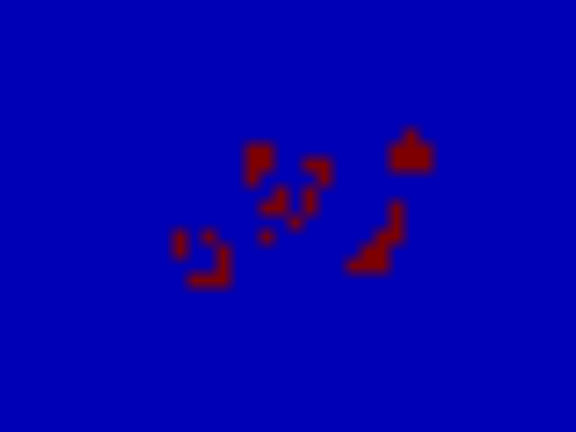
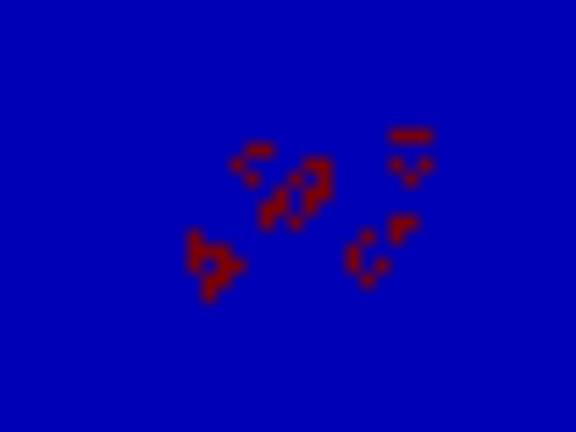
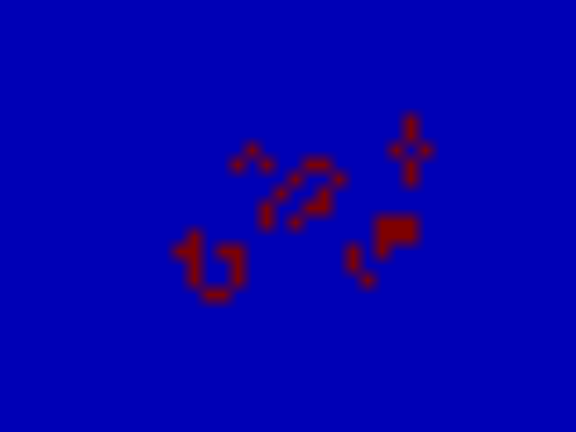
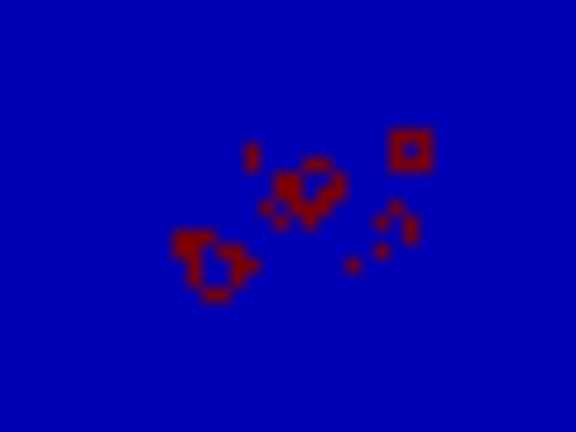
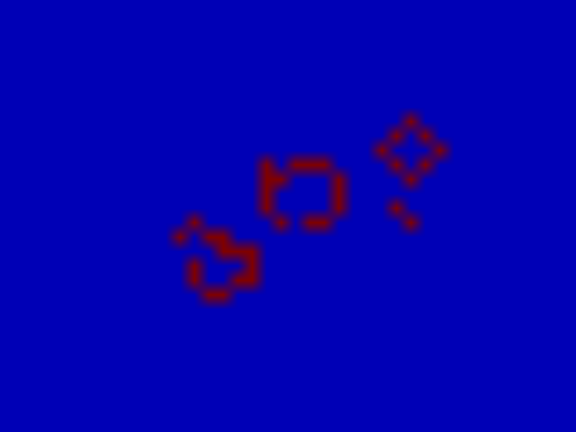
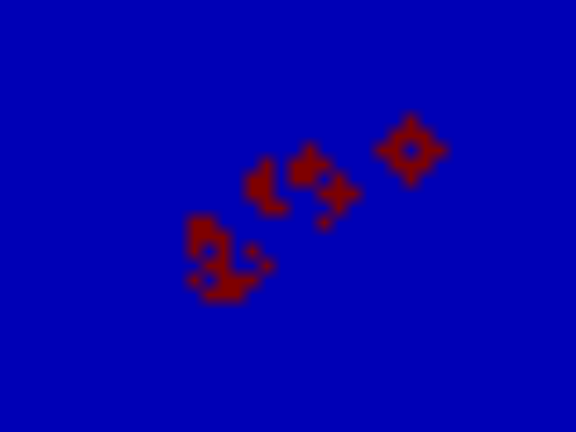
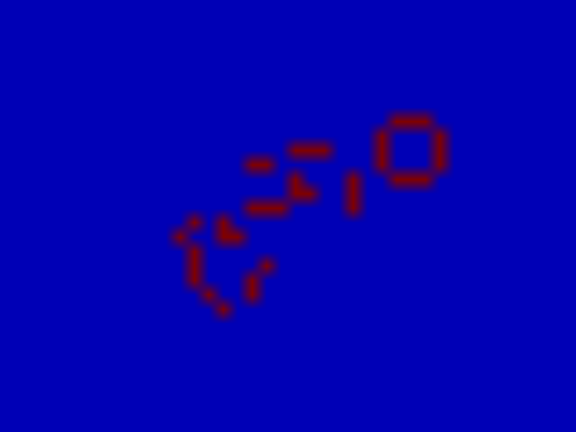
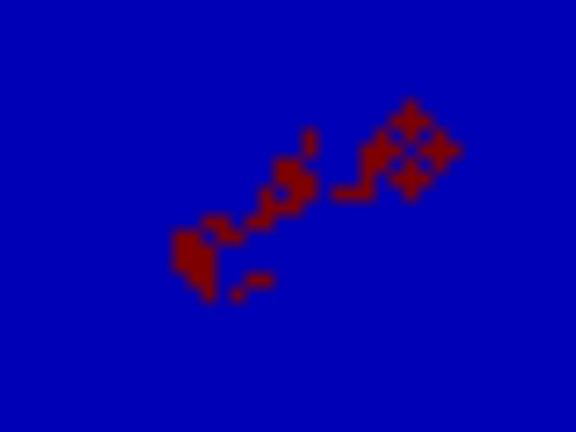
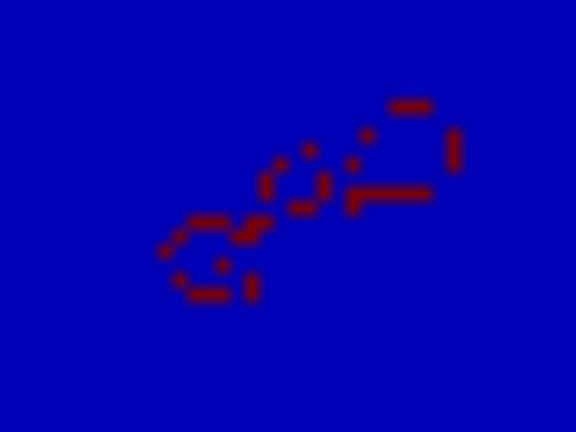
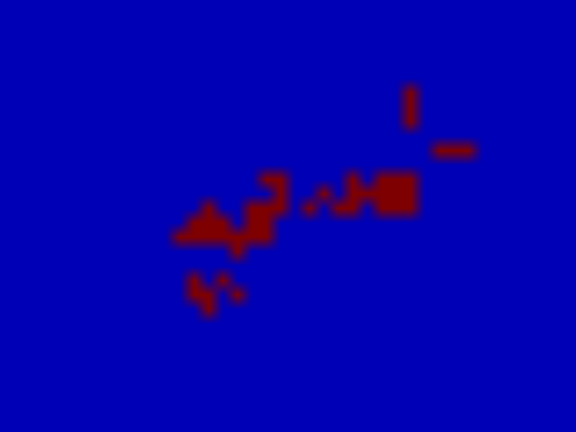
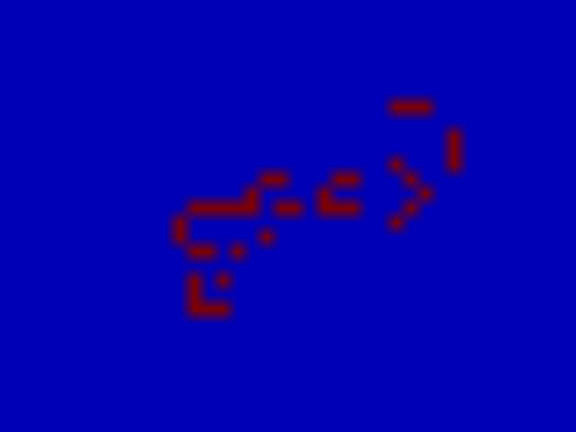
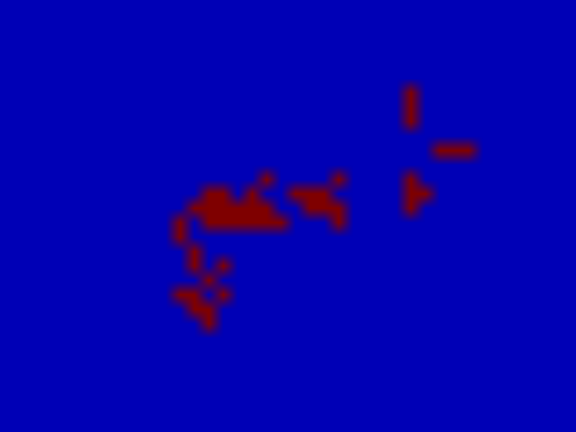
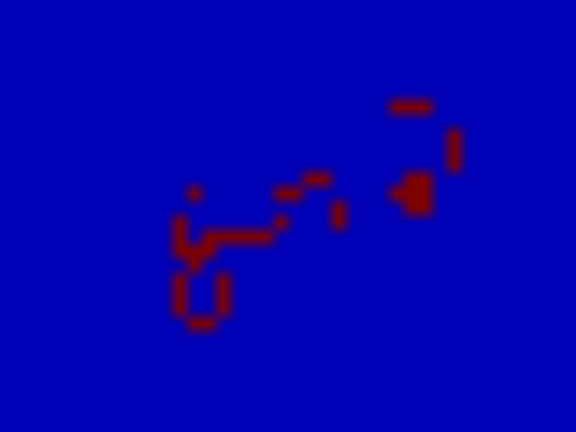
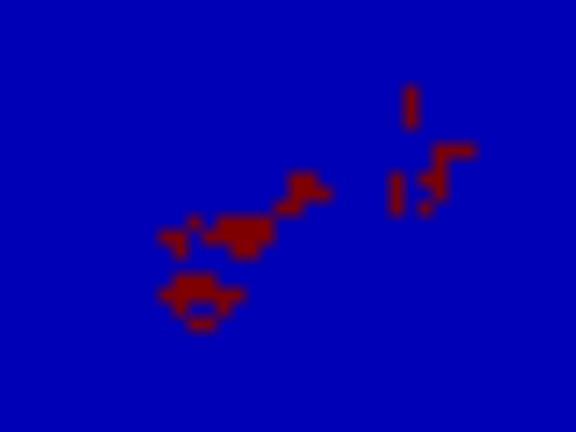
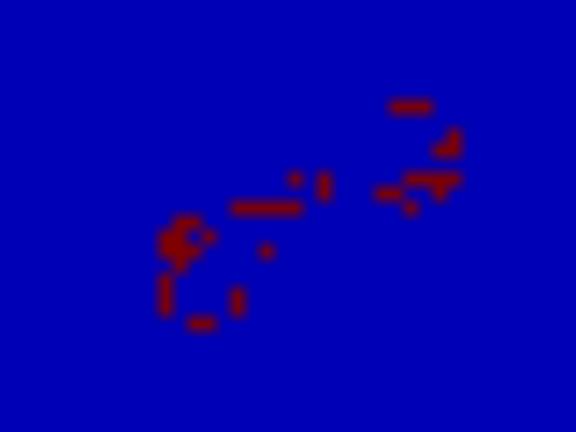
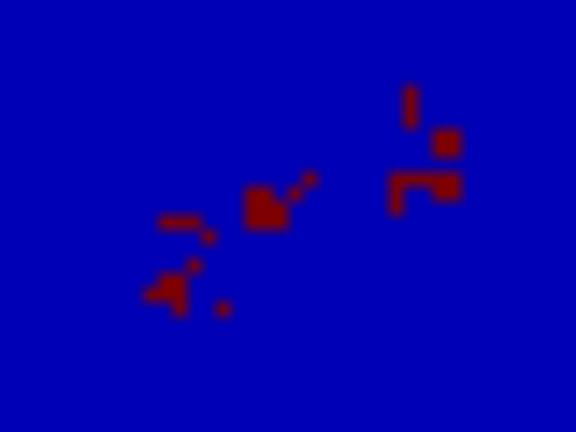
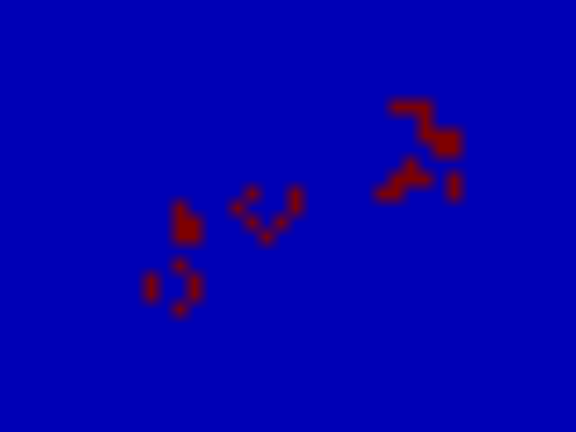
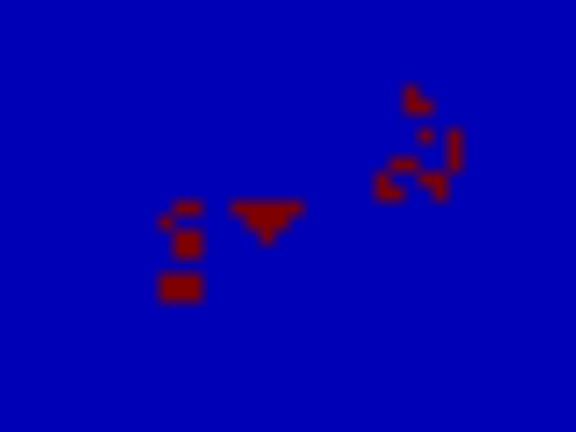
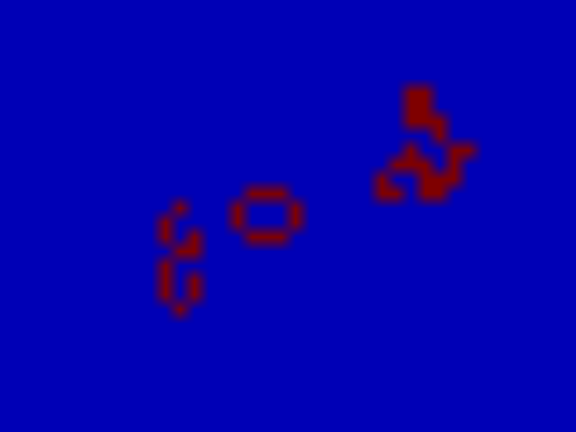
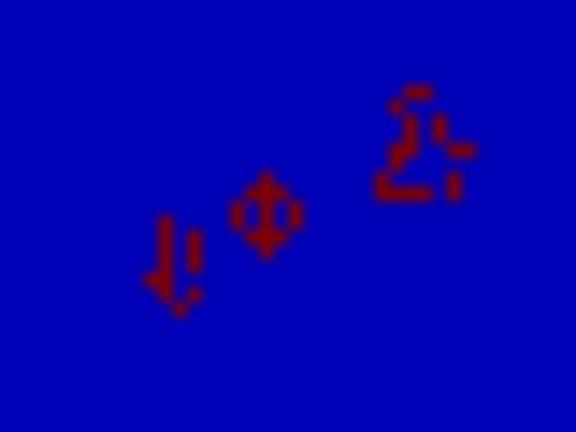

In [6]:
test_game2 = ConwayGOLGrid(20,20, optimized=True,variant="B2/S")
test_game.conway_animate(dpi=5, frames=20, mode='loop')